In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna

sns.set_theme()

In [7]:
from dataclasses import dataclass


@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [8]:
def get_portfolio_value(cash: float, long_ops: list[Operation],
                        short_ops: list[Operation], current_price: float,
                        n_shares: int) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # Todo: Add short positions value


    return val

In [9]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


In [10]:
def backtest(data, trial) -> float:
    data = data.copy()

    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.015)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.015)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    rsi_indidator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indidator.rsi()

    historic = data.dropna()
    historic['buy_signal'] = historic['rsi']< rsi_lower  # se puede optimizar
    historic['sell_signal'] = historic['rsi'] > rsi_upper  # se puede optimizar

    COM = 0.125/100
    SL = stop_loss
    TP = take_profit
    BORROW_RATE = 0.25 / 100

    cash = 1_000_000


    active_long_positions: list[Operation] = []

    portfolio_value = [cash]

    for i, row in historic.iterrows():
    
        # Close positions
        for position in active_long_positions[:]:  # Iterate over a copy of the list
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                # Close the position
                cash += row.Close * position.n_shares * (1 - COM)
                # Remove the position from active positions
                active_long_positions.remove(position)
                continue
    
        # Buy
        # Check signal
        if not row.buy_signal:
            portfolio_value.append(get_portfolio_value(
                cash, active_long_positions, [], row.Close, n_shares
            ))
            continue
    
        # Do we have enough cash?
        if cash < row.Close * n_shares * (1 + COM):
            portfolio_value.append(get_portfolio_value(
                cash, active_long_positions, [], row.Close, n_shares
            ))
            continue
    
        # Discount the cost
        cash -= row.Close * n_shares * (1 + COM)
        # Save the operation as active position
        active_long_positions.append(Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 - SL),
            take_profit=row.Close * (1 + TP),
            n_shares=n_shares,
            type='LONG'
        ))

        # This only works for long positions
        portfolio_value.append(get_portfolio_value(
            cash, active_long_positions, [], row.Close, n_shares
        ))
    
    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
    active_long_positions = []

    return(cash / 1_000_000) - 1 

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=10)

[I 2025-09-12 09:27:19,380] A new study created in memory with name: no-name-5323b4b7-6606-49c4-9d49-d1248fa933af
C:\Users\david\AppData\Local\Temp\ipykernel_20412\2860446881.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['buy_signal'] = historic['rsi']< rsi_lower  # se puede optimizar
C:\Users\david\AppData\Local\Temp\ipykernel_20412\2860446881.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['sell_signal'] = historic['rsi'] > rsi_upper  # se puede optimizar
[I 2025-09-12 09:27:

In [12]:
study.best_params

{'rsi_window': 18,
 'rsi_lower': 6,
 'rsi_upper': 75,
 'stop_loss': 0.010820751114546152,
 'take_profit': 0.01065658899279548,
 'n_shares': 229}

In [13]:
study.best_value

0.0

In [14]:
rsi_indicator = ta.momentum.RSIIndicator(
    data.Close, window=33)  # la ventana se puede optimizar
data['rsi'] = rsi_indicator.rsi()

In [15]:
historic = data.dropna()
historic['buy_signal'] = historic['rsi']< 25  # se puede optimizar
historic['sell_signal'] = historic['rsi'] > 79  # se puede optimizar

C:\Users\david\AppData\Local\Temp\ipykernel_20412\2805490884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['buy_signal'] = historic['rsi']< 25  # se puede optimizar
C:\Users\david\AppData\Local\Temp\ipykernel_20412\2805490884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['sell_signal'] = historic['rsi'] > 79  # se puede optimizar


In [16]:
historic.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
32,32,1609780200,0,2021-01-04 17:10:00,128.233398,128.249893,127.400100,127.410003,4419879.0,19.333681,True,False
33,33,1609780500,0,2021-01-04 17:15:00,127.410003,128.029998,126.760002,128.005004,2891333.0,26.622220,False,False
34,34,1609780800,0,2021-01-04 17:20:00,128.000793,128.399993,127.750000,128.289993,1956101.0,29.757129,False,False
35,35,1609781100,0,2021-01-04 17:25:00,128.289993,128.320007,127.889999,128.250000,1331407.0,29.574279,False,False
36,36,1609781400,0,2021-01-04 17:30:00,128.246902,128.310104,127.910003,128.119995,1314757.0,28.977378,False,False


# Back testing

In [17]:
COM = 0.125/100
SL = 0.125
TP = 0.138
BORROW_RATE = 0.25 / 100

cash = 1_000_000
n_shares = 385

In [18]:
active_long_positions = []

portfolio_value = [cash]

for i, row in historic.iterrows():
    #This only works for long positions
    portfolio_value.append(get_portfolio_value(
        cash, active_long_positions, [], row.Close, n_shares
    ))
    
    # Close positions
    for position in active_long_positions[:]:  # Iterate over a copy of the list
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            # Close the position
            cash += row.Close * position.n_shares * (1 - COM)
            # Remove the position from active positions
            active_long_positions.remove(position)
            continue



    # Buy
    # Check signal
    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(
        cash, active_long_positions, [], row.Close, n_shares
    ))
        continue

    # Do we have enough cash?
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(
        cash, active_long_positions, [], row.Close, n_shares
    ))
        continue
    
    # Discount the cost
    cash -= row.Close * n_shares * (1 + COM)
    # Save the operation as active position
    active_long_positions.append(Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 - SL),
            take_profit=row.Close * (1 + TP),
            n_shares=n_shares,
            type='LONG'
        ))
    
cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
active_long_positions = []

In [19]:
cash

1390822.9518371075

In [20]:
cash, len(active_long_positions)

(1390822.9518371075, 0)

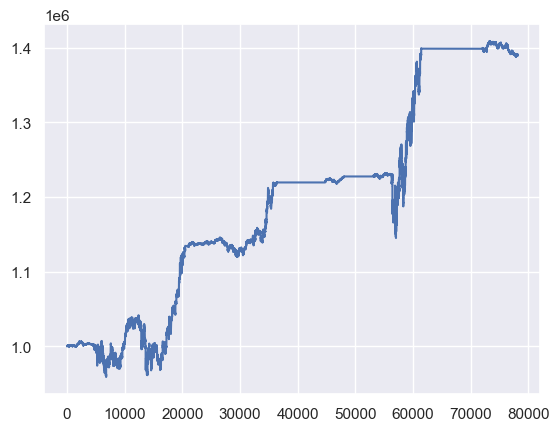

In [21]:
plt.plot(portfolio_value)